# Notebook 2: Making Predictions

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [4]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

In [5]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

In [6]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

## When do we get to inference?

Here's the one-team model from the previous notebook, again.

In [7]:
alpha = 4.4
beta = 1.8

In [8]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8839517436116413, but should be close to 0.8. Try to increase the number of tuning steps.


And here's the posterior distribution of `mu`.

In [9]:
sample_post_pymc = trace['mu']
len(sample_post_pymc)

2000

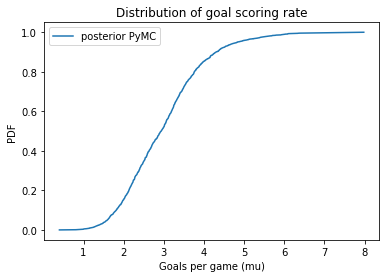

In [10]:
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

## Posterior predictive distribution

That tells us what we should believe about `mu` after we see the data, but it doesn't tell us how many goals we should expect in the future.
For that, we need the posterior predictive distribution, which we can get by running `sample_posterior_predictive`:

In [11]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=2000)

Here's what it looks like:

In [12]:
sample_post_pred_pymc = post_pred['goals']
np.mean(sample_post_pred_pymc)

3.0485

In [13]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

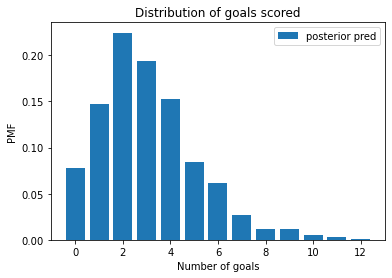

In [14]:
plot_pmf(sample_post_pred_pymc, label='posterior pred')
decorate_goals()

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [15]:
model = pm.Model()

with model:
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    mu_MTL = pm.Gamma('mu_MTL', alpha, beta)
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[5,3])
    goals_MTL = pm.Poisson('goals_MTL', mu_MTL, observed=[1,1])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_MTL, mu_TBL]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


We can use `traceplot` to review the results and do some visual diagnostics.

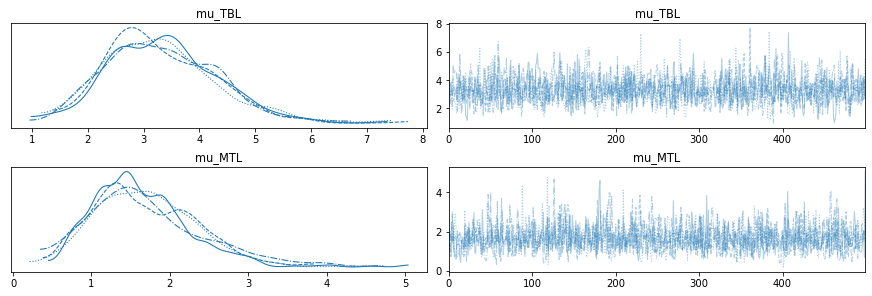

In [16]:
import arviz as az

with model:
    az.plot_trace(trace);

Here are the posterior distribitions for `mu_MTL` and `mu_TBL`.

(1.6772208826795458, 3.313337951721054)

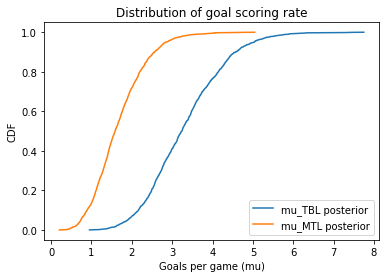

In [17]:
mu_TBL = trace['mu_TBL']
plot_cdf(mu_TBL, label='mu_TBL posterior')

mu_MTL = trace['mu_MTL']
plot_cdf(mu_MTL, label='mu_MTL posterior')

decorate_rate('CDF')
np.mean(mu_MTL), np.mean(mu_TBL)

## Predictions

Even if Tampa Bay is the better team, that doesn't mean they'll win the next game.

We can use `sample_posterior_predictive` to generate predictions.

In [18]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=2000)

Here are the posterior predictive distributions of goals scored.

In [19]:
goals_MTL = post_pred['goals_MTL'].flatten()
goals_TBL = post_pred['goals_TBL'].flatten()

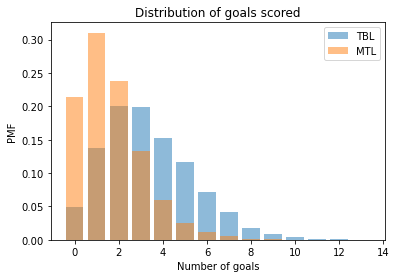

In [20]:
plot_pmf(goals_TBL, label='TBL', alpha=0.5)
plot_pmf(goals_MTL, label='MTL', alpha=0.5)
decorate_goals('PMF')

Here's the chance that Tampa Bay wins the next game.

In [21]:
win = np.mean(goals_TBL > goals_MTL)
win

0.668

The chance that they lose.

In [22]:
lose = np.mean(goals_MTL > goals_TBL)
lose

0.18775

And the chance of a tie.

In [23]:
tie = np.mean(goals_MTL == goals_TBL)
tie

0.14425

## Sudden death

In overtime, whichever team scores first wins. If we treat goal-scoring as a Poisson process, the time until the next goal is exponential with parameter `1/mu`.

We can use the samples from the posterior distributions to generate samples from the posterior predictive distribution of time until the next goal, in units of games.

In [24]:
from scipy.stats import expon

t_TBL = expon.rvs(scale=1/mu_TBL)
t_TBL.mean()

0.346281404732984

In [25]:
t_MTL = expon.rvs(scale=1/mu_MTL)
t_MTL.mean()

0.7237353697739446

On average, we expect it to take longer for Montreal to score. But the game isn't decided by averages.

**Exercise:** Compute the probability that Tampa Bay wins in overtime, then compute their total probability of winning the next game.

In [26]:
# Solution

prob_win_ot = np.mean(t_TBL < t_MTL)
prob_win_ot

0.648

In [27]:
# Solution

prob_win = win + tie * prob_win_ot
prob_win

0.761474

**Bonus exercise:** What is their probability of winning 2 of the remaining 5 games in the series?

In [28]:
# Solution

from scipy.stats import binom

xs = np.arange(6)
ys = binom(5, prob_win).pmf(xs)
ys

array([0.00077211, 0.01232446, 0.0786896 , 0.25120986, 0.40098308,
       0.25602089])

Text(0, 0.5, 'PMF')

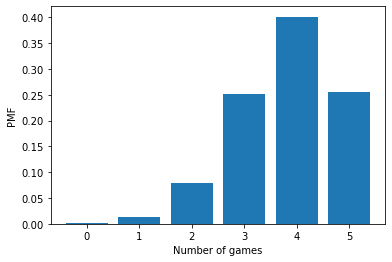

In [29]:
# Solution

plt.bar(xs, ys)
plt.xlabel('Number of games')
plt.ylabel('PMF')

In [30]:
# Solution

binom(5, prob_win).sf(1)

0.986903428566522